# Proyecto Naive Bayes
El objetivo de este proyecto es clasificar reseñas de Google Play como positivas o negativas basado en su contenido, utilizando modelos de Naive Bayes.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import joblib

In [15]:
# CARGA DE DATOS
url = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"
df = pd.read_csv(url)

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (891, 3)


,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [16]:
# INFO GENERAL DEL DATASET Y ESTADÍSTICOS DESCRIPTIVOS BÁSICOS
print("INFORMACIÓN GENERAL DEL DATASET:")
print(df.info())

print("\nESTADÍSTICOS DESCRIPTIVOS BÁSICOS:")
print(df.describe())

INFORMACIÓN GENERAL DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB
None

ESTADÍSTICOS DESCRIPTIVOS BÁSICOS:
         polarity
count  891.000000
mean     0.344557
std      0.475490
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000


Sin nulos, duplicados, ni outliers, pues se trata de texto.
Solo nos interesa la columna `review`. Eliminamos `package_name` y limpiamos texto.

In [17]:
# PREPROCESAMIENTO: Limpieza de columnas y tratamiento de texto
df = df.drop(columns=["package_name"])
df["review"] = df["review"].str.strip().str.lower()

# Separamos features y target
X = df["review"]
y = df["polarity"]

# División en train y test (estratificado por clases desbalanceadas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño train: {X_train.shape[0]}")
print(f"Tamaño test: {X_test.shape[0]}")

Tamaño train: 712
Tamaño test: 179


**Vectorización del texto**

Convertimos el texto en matriz de conteos (bag of words), ignorando stop words en inglés.

In [18]:
# Vectorización
vec = CountVectorizer(stop_words="english")
X_train_vec = vec.fit_transform(X_train).toarray()
X_test_vec = vec.transform(X_test).toarray()

print(f"Vocabulario: {len(vec.vocabulary_)} palabras únicas")

Vocabulario: 3272 palabras únicas


In [19]:
# Modelos Naive Bayes
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = roc_auc_score(y_test, y_pred)  # Usamos AUC por posible desbalanceo
    results[name] = acc
    print(f"\n--- {name} ---")
    print(f"AUC: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# Mejor NB
best_nb_name = max(results, key=results.get)
print(f"\nMejor Naive Bayes: {best_nb_name} (AUC: {results[best_nb_name]:.4f})")


--- GaussianNB ---
AUC: 0.7832
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       117
           1       0.76      0.68      0.72        62

    accuracy                           0.82       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.81      0.82      0.81       179


--- MultinomialNB ---
AUC: 0.8093
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       117
           1       0.89      0.66      0.76        62

    accuracy                           0.85       179
   macro avg       0.87      0.81      0.83       179
weighted avg       0.86      0.85      0.85       179


--- BernoulliNB ---
AUC: 0.7006
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       117
           1       0.87      0.44      0.58        62

    accuracy                           0.78       179
   macro avg       0.82     

Optimizamos el mejor modelo Naive Bayes (MultinomialNB) ajustando el hiperparámetro alpha con GridSearch.

In [20]:
# OPTIMIZACIÓN
# MultinomialNB con GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 0.001]
}

nb = MultinomialNB()
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_vec, y_train)

nb_best = grid_search.best_estimator_
y_pred_opt = nb_best.predict(X_test_vec)
auc_opt = roc_auc_score(y_test, y_pred_opt)

print("\nMejores params NB:", grid_search.best_params_)
print(f"MultinomialNB Optimizado AUC: {auc_opt:.4f}")
print(classification_report(y_test, y_pred_opt))

# Comparativa
if auc_opt > results[best_nb_name]:
    print("La optimización mejoró el modelo.")
    final_model = nb_best
    final_name = "MultinomialNB (Optimizado)"
else:
    print("La optimización no mejoró significativamente.")
    final_model = models[best_nb_name]
    final_name = best_nb_name


Mejores params NB: {'alpha': 1.0}
MultinomialNB Optimizado AUC: 0.8093
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       117
           1       0.89      0.66      0.76        62

    accuracy                           0.85       179
   macro avg       0.87      0.81      0.83       179
weighted avg       0.86      0.85      0.85       179

La optimización no mejoró significativamente.


Probamos con Random Forest y SVM para ver si superan al Naive Bayes.

In [21]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
auc_rf = roc_auc_score(y_test, y_pred_rf)

print(f"\nRandom Forest AUC: {auc_rf:.4f}")

# SVM
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)
auc_svm = roc_auc_score(y_test, y_pred_svm)

print(f"SVM AUC: {auc_svm:.4f}")

# Selección del modelo final
best_auc = roc_auc_score(y_test, final_model.predict(X_test_vec))

if auc_rf > best_auc:
    final_model = rf
    final_name = "Random Forest"
    best_auc = auc_rf
    
if auc_svm > best_auc:
    final_model = svm
    final_name = "SVM"
    best_auc = auc_svm

print(f"\nModelo ganador final: {final_name} (AUC: {best_auc:.4f})")


Random Forest AUC: 0.7836
SVM AUC: 0.7807

Modelo ganador final: MultinomialNB (AUC: 0.8093)


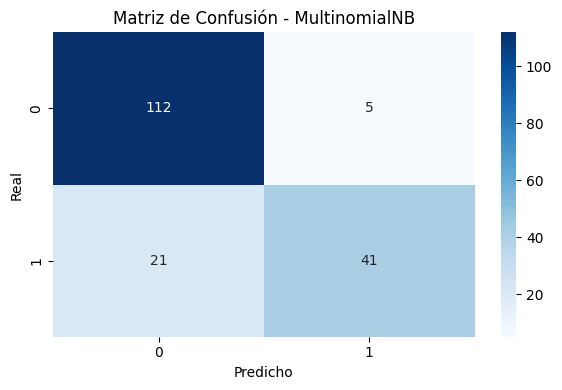

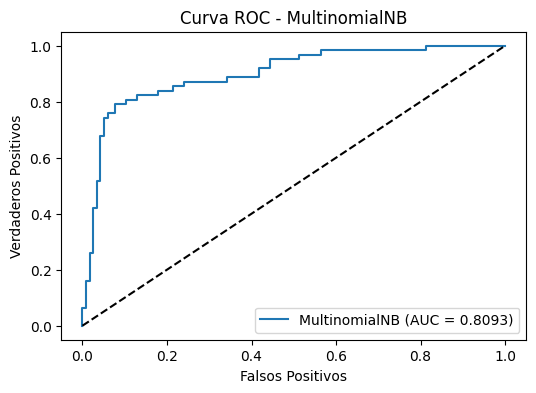

In [22]:
# Matriz de confusión
y_pred_final = final_model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusión - {final_name}")
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()


# Evaluación del modelo final (Curva ROC)
y_prob = final_model.predict_proba(X_test_vec)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"{final_name} (AUC = {best_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.title(f"Curva ROC - {final_name}")
plt.legend()
plt.show()

In [23]:
# GUARDADO DEL MODELO
joblib.dump(final_model, 'sentiment_model.pkl')
joblib.dump(vec, 'vectorizer.pkl')
print("Modelo y vectorizador guardados.")

Modelo y vectorizador guardados.


# Conclusiones

Con este proyecto, comprobamos la eficacia de los modelos Naive Bayes para el análisis de sentimientos en datos de texto. En nuestro caso particular, logramos obtener una mayor precisión con el modelo Naive Bayes Multinomial inicial.

Aunque aplicamos técnicas de mejora, como la optimización de su hiperparámetro alpha, y probamos alternativas más complejas como Random Forest (RF) y las Máquinas de Vectores de Soporte (SVM), ninguno de ellos superó el rendimiento del Naive Bayes básico. Esto demuestra la gran solidez y sencillez de este modelo para tareas de clasificación basadas en el conteo de palabras.
